In [55]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc

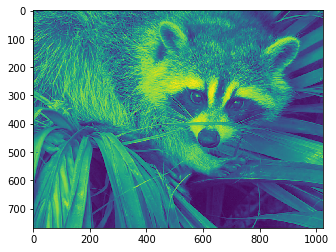

In [61]:
face = misc.face()
data = face[:,:,0] / 255
plt.imshow(data)

In [62]:
data.shape

(768, 1024)

In [69]:
m = 768 # number of data points
n = 1024 # dimensional of data
A = data # data matrix
l = 100 # dimension of low diml space

iterations = 20

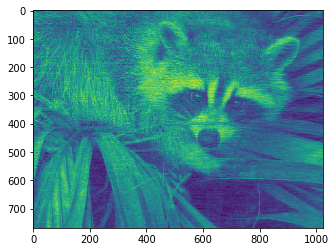

In [72]:
results = np.empty(iterations)e

for i in range(iterations):
    omega = random.randn(n,l)
    Y = A @ omega
    q, r = np.linalg.qr(Y)
    results[i] = np.linalg.norm(A - (q @ q.T @ A)) / np.linalg.norm(A) #conjugate transpose should be used for complex entries
    

In [73]:
example = q @ q.T @ A

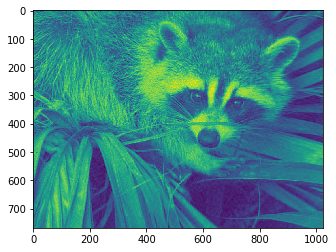

In [84]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
approx = pca.inverse_transform(pca.fit_transform(data))
plt.imshow(approx)

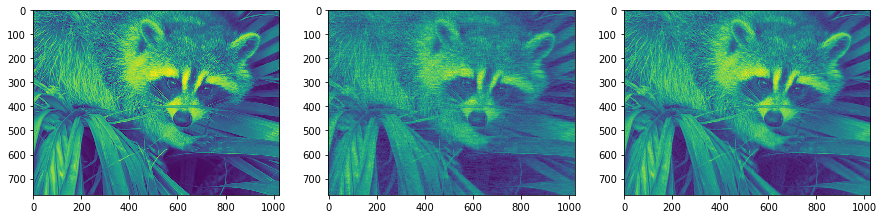

In [87]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(data)
ax[1].imshow(example)
ax[2].imshow(approx)